# PART-A
## 1. Import and analyse the data set. [5 Marks] 
Hint: - Use `imdb.load_data()` method
 - Get train and test set
 - Take 10000 most frequent words

In [1]:
import pandas as pd
import numpy as np
from langdetect import detect
import re
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score, average_precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn import preprocessing
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json
import random

In [2]:
top_nwords = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_nwords)

#### About imdb dataset:
- This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). 
- Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). 
- For convenience, words are indexed by overall frequency in the dataset.For example, integer "3" encodes the 3rd most frequent word in the data. 

#### load_data function returns the below:
- x_train, x_test: lists of sequences, which are lists of indexes (integers). Each index represent the frequency rank of the word in the dataset. Since we have given num_words as 10000, the maximum possible index value will be 9999 (i.e num_words-1). Meaning, we are considering words which are top 10000 frequent words in the dataset. If no num_words is defined all words are considered. The index value starts from "1". There is no index "0" and it does not stand for a specific word, but instead is used to encode the pad token (padding is explained later). <br>
Note: If the `maxlen` argument was specified, the largest possible sequence length is `maxlen`. Since no 'maxlen' is defined the sequences in x_train and x_test can be of any length.

- y_train, y_test: lists of integer labels - 1 or 0 representing positive or negative sentiment.

In [3]:
print("Shape of x_train :{}".format(x_train.shape))
print("Shape of y_train :{}".format(y_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))
print("Shape of y_test  :{}".format(y_test.shape))

Shape of x_train :(25000,)
Shape of y_train :(25000,)
Shape of x_test  :(25000,)
Shape of y_test  :(25000,)


In [4]:
# Let us see a sample item from x_train
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
# Let us check the length of sample sequences in x_train
for i in range(10):
    print(len(x_train[i]))

218
189
141
550
147
43
123
562
233
130


In [6]:
print(x_test[0])

[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 7944, 451, 202, 14, 6, 717]


In [7]:
# Let us check the length of sample sequences in x_train
for i in range(10):
    print(len(x_test[i]))

68
260
603
181
108
132
761
180
134
370


#### From the above displays, it is evident that the sequences in both x_train and x_test are of various length. It needs padding in order to have same/consistent length for all sequences.

In [8]:
y_train

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [9]:
y_test

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [10]:
#Let us see the words that are assigned to each index
word_dict = imdb.get_word_index()
print("Length of the dictionary :{}".format(len(word_dict)))
print("\nSample words and its indices: \n")
print(list(word_dict.items())[:5])

Length of the dictionary :88584

Sample words and its indices: 

[('fawn', 34701), ('tsukino', 52006), ('nunnery', 52007), ('sonja', 16816), ('vani', 63951)]


- There are totally 88584 distinct words in the dataset

In [11]:
reverse_word_dict = {value:key for key, value in word_dict.items()}
print("\nSample indices and words : \n")
print(list(reverse_word_dict.items())[:5])


Sample indices and words : 

[(34701, 'fawn'), (52006, 'tsukino'), (52007, 'nunnery'), (16816, 'sonja'), (63951, 'vani')]


In [12]:
# Since index represents frequency rank of the word in the dataset, there may not be index 0 in reverse_word_dict. 
# Let us confirm the same.
if reverse_word_dict.get(0) == None:
  print("Index 0 not present")
else:
  print("Index 0 present")

Index 0 not present


In [13]:
# lets get the 10 top frequent words
for i in range(1,11):
    print(i, reverse_word_dict[i])

1 the
2 and
3 a
4 of
5 to
6 is
7 br
8 in
9 it
10 i


- We have totally 88584 distinct words and the word 'the' is the most frequent word and the word 'and' is the second most frequent word.

## 2. Perform relevant sequence adding on the data. [5 Marks]

In [14]:
# To understand what sequence adding is needed in the data, First let us try to decode the indices to words for a sample sequence in x_train
print(' '.join(reverse_word_dict[id] for id in x_train[0]))


the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have tw

##### Modifying index:
The above sentence doesn't make any sense and it all looks giberish. The reason is given as below:
- When loading the dataset,the indices are offset by 3 because 0, 1 and 2 are reserved indices for "padding", "start of sequence" and "unknown".
- "start of sequence" is defined by start_char: int. The start of a sequence will be marked with this character. Defaults to 1 because 0 is usually the padding character.
- "unknown" or "Out Of Vocabulary" is defined by oov_char: int. The out-of-vocabulary character.

Since indices 0,1, and 2 reserved, the actual index start from 3. In order to sync with indices of x_train and x_test we need to add +3 to their indices. 

In [15]:
# Let us now try modifying the indices
word_dict1 = {key:(value+3) for key, value in word_dict.items()}

# Padding
word_dict1[' '] = 0

# start of sequence
word_dict1['#'] = 1  

# Out Of Vocabulary
word_dict1['?'] = 2 

reverse_word_dict1 = {value:key for key, value in word_dict1.items() }
print(' '.join(reverse_word_dict1[id] for id in x_train[0]))

# this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

- Now the statement makes sense and gives meaning. All needed relevant sequences are added to the data.

## 3. Perform following data analysis: [5 Marks]
• Print shape of features and labels
• Print value of any one feature and it's label

In [16]:
print("Printing Shape of features in train and test set:")
print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Printing Shape of labels in train and test set:")
print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

Printing Shape of features in train and test set:
Shape of x_train :(25000,)
Shape of x_test  :(25000,)
Printing Shape of labels in train and test set:
Shape of y_train :(25000,)
Shape of y_test  :(25000,)


In [18]:
print("Printing value of any one random feature and it's label:")
rnd=np.random.randint(0, len(x_train))
print("Value of random feature id {} in x_train : \n{}".format(rnd,x_train[rnd]))
print("\nLabel assigned for the random feature  : {}".format(y_train[rnd]))

Printing value of any one random feature and it's label:
Value of random feature id 22059 in x_train : 
[1, 13, 610, 930, 8, 149, 14, 22, 5, 95, 5372, 15, 101, 440, 7, 6, 3984, 414, 200, 4, 156, 16, 2, 34, 4, 1744, 6663, 150, 13, 244, 24, 6, 2, 11, 101, 96, 21, 8, 8520, 2, 33, 257, 85, 127, 24, 6, 52, 22, 97, 9970, 2, 9, 4689, 31, 7, 4, 249, 156, 11, 4, 182, 33, 14, 58, 2413, 27, 239, 11, 4, 558, 373, 113, 7, 538, 27, 8550, 1191, 9, 220, 17, 78, 17, 27, 2, 1191, 798, 89, 111, 53, 7, 134, 108, 2828, 2828, 4040, 4040, 307, 2373, 81, 75, 28, 8, 2712, 159, 4, 22, 1188, 3547, 15, 4, 1209, 681, 4, 1148, 681, 525, 127, 24, 5220, 2261, 414]

Label assigned for the random feature  : 0


## 4. Decode the feature value to get original sentence [5 Marks]

In [19]:
rnd=np.random.randint(0, len(x_train))
print("Value of random feature id {} in x_train :".format(rnd))
print(' '.join(reverse_word_dict1[id] for id in x_train[rnd]))

print("\nLabel assigned for the random feature  : {}".format(y_train[rnd]))

Value of random feature id 19687 in x_train :
# here's a real weirdo for you it starts out with another take off on the psycho shower scene on campus then gets ? when several ? and their ? boyfriends head south for spring break the trouble starts when they drive into the redneck county ruled by homicidal sheriff dean one of the college ? wanders into the woods witnesses a murder by the sheriff and has her head blown open then it's lets rip off ? county line time as dean stalks traps and ? the witless witnesses one by one tony march is on target as the evil shotgun happy dean the movie's overall tone is truly disturbing the ending is so abrupt you almost think the director ran out of film it's also a study in despair shallow grave is a must for ? ? and ? the world over

Label assigned for the random feature  : 1


## 5. Design, train, tune and test a sequential model. [5 Marks]
Hint: The aim here Is to import the text, process it such a way that it can be taken as an inout to the ML/NN classifiers. Be 
analytical and experimental here in trying new approaches to design the best model.

In [20]:
# Let us check the length of sample sequences in x_train
for i in range(10):
    print(len(x_train[i]))

218
189
141
550
147
43
123
562
233
130


In [21]:
# Let us check the length of sample sequences in x_train
for i in range(10):
    print(len(x_test[i]))

68
260
603
181
108
132
761
180
134
370


#### From the above displays, it is evident that the sequences in both x_train and x_test are of various length. It needs padding in order to have same/consistent length for all sequences.

#### Let us set  `maxlen` argument as 500, meaning, the largest possible sequence length is 500. If the sequnce is short of this length it will be padded with default value of 0. Note in word_dict ' ' is assigned for the padded value 0.

In [22]:
max_review_length = 500
x_train = pad_sequences(x_train, maxlen=max_review_length)
x_test = pad_sequences(x_test, maxlen=max_review_length)

In [23]:
# Let us check the length of sample sequences in x_train after padding
for i in range(10):
    print(len(x_train[i]))

500
500
500
500
500
500
500
500
500
500


In [24]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [25]:
# Let us check the length of sample sequences in x_train after padding
for i in range(10):
    print(len(x_test[i]))

500
500
500
500
500
500
500
500
500
500


In [30]:
embedding_vector_length = 32
max_review_length = 500
top_nwords = 10000

## Sequential Model 
model = Sequential()
model.add(Embedding(top_nwords, embedding_vector_length, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           320000    
                                                                 
 flatten_1 (Flatten)         (None, 16000)             0         
                                                                 
 dense_3 (Dense)             (None, 16)                256016    
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 576,305
Trainable params: 576,305
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
seq_model = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=0)

In [28]:
seq_model_train_res = model.evaluate(x_train, y_train)
seq_model_test_res = model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 1.5413 - accuracy: 0.8504


In [29]:
print("Train Loss      : {}  Train accuracy       : {}".format(seq_model_train_res[0],seq_model_train_res[1]))
print("Test Loss       : {}  Test accuracy        : {}".format(seq_model_test_res[0],seq_model_test_res[1]))

Train Loss      : 4.028630371522013e-07  Train accuracy       : 1.0
Test Loss       : 1.5412719249725342  Test accuracy        : 0.8504400253295898


In [31]:
## Let us tune the model with additional parameters/early stopping. Re-executing the model and then fitting again
early_stop = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=100)
tuned_model = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000, batch_size=128, callbacks=[early_stop], verbose=0)

Epoch 102: early stopping


In [32]:
seq_model_train_res = model.evaluate(x_train, y_train)
seq_model_test_res = model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 1.1628 - accuracy: 0.8718


In [33]:
print("Train Loss      : {} ; Train accuracy       : {}".format(seq_model_train_res[0],seq_model_train_res[1]))
print("Test Loss       : {} ; Test accuracy        : {}".format(seq_model_test_res[0],seq_model_test_res[1]))

Train Loss      : 4.66674965338143e-09 ; Train accuracy       : 1.0
Test Loss       : 1.1627787351608276 ; Test accuracy        : 0.8718000054359436


#### The tuned model has given accuracy score of 87.18% in test set.

[]

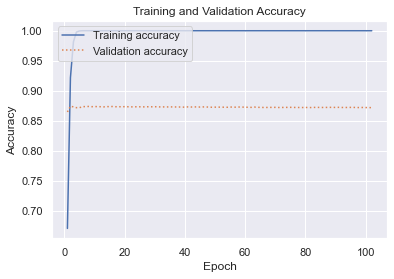

In [35]:
%matplotlib inline

sns.set()
acc = tuned_model.history['accuracy']
val = tuned_model.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

[]

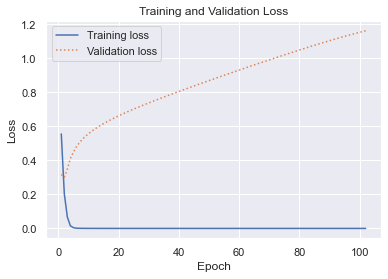

In [36]:
loss = tuned_model.history['loss']
val = tuned_model.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

## 6. Use the designed model to print the prediction on any one sample. [5 Marks]

In [37]:
from keras_preprocessing import sequence

def predict_sentiment(text):

    # Removing punctuations if any    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lower case
    text = text.lower().split(' ')
    text = [word for word in text if word.isalpha()]

    # Generate input tensor
    input = [1] # for start of sentence
    for word in text:
        if word in word_dict and word_dict[word] < top_nwords:
            input.append(word_dict[word])
        else:
            input.append(2) # for unknown
            
    # Pad the input to have consistent length of 500
    max_review_length=500    
    padded_input = sequence.pad_sequences([input], maxlen=max_review_length)

    # Invoke the model and return the result
    result = model.predict(np.array([padded_input][0]))[0][0]
    return result

In [38]:
predict_sentiment('Very good movie. Great acting and very entertaining..')

1/1 [==============================] - 0s 79ms/step


0.9999588

- Correctly predicted as positive review

In [45]:
predict_sentiment('very poor screen play and not so gripping story line. worst film') 

1/1 [==============================] - 0s 19ms/step


0.15202557

- Correctly predicted as negative review

In [46]:
predict_sentiment('such a boring movie to watch for 2 hrs') 

1/1 [==============================] - 0s 20ms/step


0.20715088

- Correctly predicted as negative review

In [47]:
predict_sentiment('happy to watch this movie with friends and family! great acting by all actors! highly recommend!')

1/1 [==============================] - 0s 20ms/step


0.9908558

- Correctly predicted as positive review

In [53]:
predict_sentiment('Not so great movie. One time watchable. Poor acting.')

1/1 [==============================] - 0s 19ms/step


0.6519833

- Correctly predicted as average review.

# PartB
## 1. Read and explore the data [3 Marks]

In [54]:
# Function to read the given json file
def read_json(file_nm):
    for line in open(file_nm, 'r'):
        yield eval(line)

In [55]:
sh_data = list(read_json("./Sarcasm_Headlines_Dataset.json"))

In [107]:
sh_data[:2]

[{'is_sarcastic': 1,
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'},
 {'is_sarcastic': 0,
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'}]

In [57]:
sh_df=pd.DataFrame.from_dict(sh_data)
sh_df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [58]:
sh_df.shape

(28619, 3)

In [59]:
sh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [60]:
sh_df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

<AxesSubplot:xlabel='is_sarcastic', ylabel='Count'>

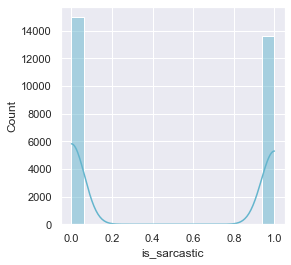

In [61]:
plt.figure(figsize=(4,4))
sns.histplot(data=sh_df,x="is_sarcastic",kde=True,color="c")

## 2. Retain relevant columns [3 Marks]

In [62]:
# Only headline and is_sarcastic are relevant in this dataframe. 
sh_df1=sh_df[['headline','is_sarcastic']]
sh_df1.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [63]:
sh_df1.shape

(28619, 2)

In [64]:
sh_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      28619 non-null  object
 1   is_sarcastic  28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


## 3. Get length of each sentence [3 Marks]

In [65]:
# Getting the length of each sentence as is.
sh_df1['sntnc_len']=sh_df1['headline'].apply(lambda s: len(s))
sh_df1.head()

,headline,is_sarcastic,sntnc_len
0,thirtysomething scientists unveil doomsday clo...,1,61
1,dem rep. totally nails why congress is falling...,0,79
2,eat your veggies: 9 deliciously different recipes,0,49
3,inclement weather prevents liar from getting t...,1,52
4,mother comes pretty close to using word 'strea...,1,61


In [66]:
# Let us take only Alpha numeric characters and ignore all punctuations 
sh_df1['headline'] = sh_df1['headline'].apply(lambda x: x.lower())
sh_df1['headline'] = sh_df1['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [67]:
# Now let us calculate the length of sentences again after keeping only alphas numeric characters
sh_df1['sntnc_len']=sh_df1['headline'].apply(lambda s: len(s))
sh_df1.head()

,headline,is_sarcastic,sntnc_len
0,thirtysomething scientists unveil doomsday clo...,1,61
1,dem rep totally nails why congress is falling ...,0,77
2,eat your veggies 9 deliciously different recipes,0,48
3,inclement weather prevents liar from getting t...,1,52
4,mother comes pretty close to using word stream...,1,59


## 4. Define parameters [3 Marks]

#### Defining parameters for Tokenizer
- We can define the below parameters and keep rest all with defualt values. <br>
`num_words` : the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.<br> Considering the total number of records of 28619 records i.e sequences, let us keep top 10000 frequent words, which is more than enough to pick all possible words. so num_words can be 10000.<br>
`oov_token` : if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence. calls<br> oov_token='OOV'


In [68]:
# max_features: Number of words to take from tokenizer
max_features = 10000 # will be assigned for num_words
oov_token="<OOV>"

#### Defining parameters for pad_sequences
- We can define the below parameters and keep rest all with defualt values. <br>
`padding` : String, "pre" or "post" (optional, defaults to "pre"): pad either before or after each sequence.<br> we can set padding as 'post' <br>
`truncating` : String, "pre" or "post" (optional, defaults to "pre"): remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.<br> we can set truncating as 'post' <br>
`maxlen` : Optional Int, maximum length of all sequences. If not provided, sequences will be padded to the length of the longest individual sequence. <br> To set this we need to explore the data more. Below is the analysis


In [69]:
# Let us explore the data in order to set values for parameters
# For setting num_words parameter, let us analyze length of sentences

max_sntnc_len = sh_df1['sntnc_len'].max()
print("Maximum length of the sentence : {}".format(max_sntnc_len))

Maximum length of the sentence : 910


In [70]:
# Let us take top 20 sentence lengths sorted in descending order
sh_df2 = sh_df1.sort_values('sntnc_len',ascending = False)
sh_df2.head(20)

,headline,is_sarcastic,sntnc_len
7302,hot wheels ranked number one toy for rolling d...,1,910
2146,maya angelou poet author civil rights activist...,1,237
24815,elmore leonard modern prose master noted for h...,1,234
23598,occasionally you realize someone you thought w...,0,224
16588,12 years a slave captain phillips american hus...,1,209
26597,jared kushner claims that russian interference...,1,202
4688,roy moore on pedophilia accusers these women a...,1,187
27972,mia farrow its possible my son was fathered by...,1,186
25133,sessions argues justice department will not be...,1,162
2426,report doing your part to stop climate change ...,1,154


- As we see above, the maximum sentence length is 910, but it is just for one record. The sentence lengths have consistently declined to 100s. Considering the total number of rows of 28619, and sentence lengths have declined to 100s within 20 top records, we can set maxlen as 100.

In [71]:
# maxlen: Maximum length of each sentence
max_length = 100 # will be assigned for max_len

#### Defining size of embedding vector
- embedding_dim can be defined as 100. This will be output dimension of the Kera embedding layer. 

#### Consolidated definition of parameters:

In [72]:
# max_features: Number of words to take from tokenizer
max_features = 10000 # will be assigned for num_words
oov_token="<OOV>"

# maxlen: Maximum length of each sentence
max_length = 100       # will be assigned for maxlen

padding='post'
truncating='post'

# embedding_size: Size of embedding vector
embedding_dim = 100

## 5. Get indices for words [3 Marks]

In [73]:
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(sh_df1['headline'])
word_index = tokenizer.word_index

In [109]:
print("Total number of word,index pairs :{}".format(len(word_index)))

list(word_index.items())[:10]

Total number of word,index pairs :29646


[('<OOV>', 1),
 ('to', 2),
 ('of', 3),
 ('the', 4),
 ('in', 5),
 ('for', 6),
 ('a', 7),
 ('on', 8),
 ('and', 9),
 ('with', 10)]

In [75]:
idx_word = tokenizer.index_word

In [110]:
print("Total number of index,word pairs :{}".format(len(idx_word)))
list(idx_word.items())[:10]

Total number of index,word pairs :29646


[(1, '<OOV>'),
 (2, 'to'),
 (3, 'of'),
 (4, 'the'),
 (5, 'in'),
 (6, 'for'),
 (7, 'a'),
 (8, 'on'),
 (9, 'and'),
 (10, 'with')]

In [77]:
word_counts = tokenizer.word_counts
num_words = len(word_counts)

In [78]:
print("Total number of words :{}".format(num_words))

Total number of words :29645


In [112]:
list(word_counts.items())[:10]

[('thirtysomething', 1),
 ('scientists', 103),
 ('unveil', 13),
 ('doomsday', 5),
 ('clock', 18),
 ('of', 6263),
 ('hair', 59),
 ('loss', 38),
 ('dem', 4),
 ('rep', 25)]

## 6. Create features and labels [3 Marks]

In [80]:
sequences = tokenizer.texts_to_sequences(sh_df1['headline'].values)

In [81]:
len(sequences)

28619

In [114]:
# Let us see the length of each sequence 
for i in range(10):
    print("index : {} , Seq_length : {}".format(i, len(sequences[i])))

index : 0 , Seq_length : 8
index : 1 , Seq_length : 13
index : 2 , Seq_length : 7
index : 3 , Seq_length : 8
index : 4 , Seq_length : 9
index : 5 , Seq_length : 3
index : 6 , Seq_length : 9
index : 7 , Seq_length : 13
index : 8 , Seq_length : 12
index : 9 , Seq_length : 6


In [83]:
# max_length is set to 100 and padded to have consistent length for all sequences
max_length = 100
features= pad_sequences(sequences,padding='post',truncating='post',maxlen=max_length)
features

array([[   1,  337, 3106, ...,    0,    0,    0],
       [7348, 1732,  733, ...,    0,    0,    0],
       [ 893,   35,    1, ...,    0,    0,    0],
       ...,
       [   4,   97,  590, ...,    0,    0,    0],
       [1830, 1284, 3255, ...,    0,    0,    0],
       [ 210, 3224,   21, ...,    0,    0,    0]])

In [84]:
len(features)

28619

In [115]:
# Now let us see length of sample sequences after padding
for i in range(10):
    print("index : {} , Seq_length : {}".format(i, len(features[i])))

index : 0 , Seq_length : 100
index : 1 , Seq_length : 100
index : 2 , Seq_length : 100
index : 3 , Seq_length : 100
index : 4 , Seq_length : 100
index : 5 , Seq_length : 100
index : 6 , Seq_length : 100
index : 7 , Seq_length : 100
index : 8 , Seq_length : 100
index : 9 , Seq_length : 100


In [86]:
# Let us see sample feature
features[0]

array([   1,  337, 3106, 6323, 2319,    3,  672, 1139,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [87]:
labels = np.array(sh_df1['is_sarcastic'].values.tolist())

In [88]:
labels

array([1, 0, 0, ..., 0, 1, 1])

In [89]:
rnd=np.random.randint(0, len(features))
print("Sample random feature                    : \n{}".format(features[rnd]))

print("\nLabel assigned for the random feature  : {}".format(labels[rnd]))

Sample random feature                    : 
[4148    1  372  274    3  247 1697 5430 1157    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

Label assigned for the random feature  : 0


## 7. Get vocabulary size [3 Marks]

In [90]:
word_counts = tokenizer.word_counts
vocab_size = len(word_counts)

In [91]:
print("Total vocabulary size :{}".format(vocab_size))

Total vocabulary size :29645


In [116]:
list(word_counts.items())[:10]

[('thirtysomething', 1),
 ('scientists', 103),
 ('unveil', 13),
 ('doomsday', 5),
 ('clock', 18),
 ('of', 6263),
 ('hair', 59),
 ('loss', 38),
 ('dem', 4),
 ('rep', 25)]

## 8. Create a weight matrix using GloVe embeddings [3 Marks]

In [93]:
# Let us download the pre-trained globalvector model 
import zipfile
from zipfile import ZipFile
# Extracting glove.6B.zipfile using python
zip_file_path='glove.6B.zip'
with ZipFile(zip_file_path, 'r') as zip:
  zip.extractall()

In [94]:
embeddings_index = {};
with open('glove.6B.100d.txt',encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coefs

In [95]:
# creating embedding matrix
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [96]:
embeddings_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [-0.12864999, -0.67440999, -0.74498999, ...,  0.63151997,
        -0.26293999,  1.12390006],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.20939   ,  0.23797999,  0.79356003, ..., -0.2342    ,
        -0.087866  , -0.16031   ]])

In [97]:
embeddings_matrix.shape

(29646, 100)

## 9. Define and compile a Bidirectional LSTM model. [3 Marks]
 Hint: Be analytical and experimental here in trying new approaches to design the best model.

In [98]:
x_train, x_test, y_train, y_test = train_test_split(features,labels,random_state=5,test_size = 0.2)

In [99]:
print("Shape of x_train :{}".format(x_train.shape))
print("Shape of y_train :{}".format(y_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))
print("Shape of y_test  :{}".format(y_test.shape))

Shape of x_train :(22895, 100)
Shape of y_train :(22895,)
Shape of x_test  :(5724, 100)
Shape of y_test  :(5724,)


In [100]:
# Define Bi-directional LSTM model
lstm_model = keras.Sequential([
    keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length,weights=[embeddings_matrix], trainable=False),
    keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)),

    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2964600   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dropout (Dropout)           (None, 6)                

## 10. Fit the model and check the validation accuracy [3 Marks]

In [101]:
num_epochs = 20
lstm_model_fitted = lstm_model.fit(x_train, y_train , epochs=num_epochs, validation_data=(x_test,y_test))

Epoch 1/20
716/716 [==============================] - 93s 123ms/step - loss: 0.5019 - accuracy: 0.7489 - val_loss: 0.3926 - val_accuracy: 0.8279
Epoch 2/20
716/716 [==============================] - 87s 122ms/step - loss: 0.3818 - accuracy: 0.8291 - val_loss: 0.3685 - val_accuracy: 0.8426
Epoch 3/20
716/716 [==============================] - 91s 127ms/step - loss: 0.3449 - accuracy: 0.8529 - val_loss: 0.3502 - val_accuracy: 0.8447
Epoch 4/20
716/716 [==============================] - 89s 124ms/step - loss: 0.2968 - accuracy: 0.8767 - val_loss: 0.3351 - val_accuracy: 0.8539
Epoch 5/20
716/716 [==============================] - 85s 119ms/step - loss: 0.2613 - accuracy: 0.8919 - val_loss: 0.3264 - val_accuracy: 0.8625
Epoch 6/20
716/716 [==============================] - 100s 139ms/step - loss: 0.2374 - accuracy: 0.9036 - val_loss: 0.3460 - val_accuracy: 0.8574
Epoch 7/20
716/716 [==============================] - 93s 130ms/step - loss: 0.2154 - accuracy: 0.9138 - val_loss: 0.3339 - val_a

In [102]:
lstm_model_train_res = lstm_model.evaluate(x_train, y_train)
lstm_model_test_res = lstm_model.evaluate(x_test, y_test)

179/179 [==============================] - 7s 38ms/step - loss: 0.7944 - accuracy: 0.8622


In [103]:
print("Train Loss      : {} ; Train accuracy       : {}".format(lstm_model_train_res[0],lstm_model_train_res[1]))
print("Test Loss       : {} ; Test accuracy        : {}".format(lstm_model_test_res[0],lstm_model_test_res[1]))

Train Loss      : 0.017695553600788116 ; Train accuracy       : 0.994758665561676
Test Loss       : 0.7943642139434814 ; Test accuracy        : 0.8621593117713928


[]

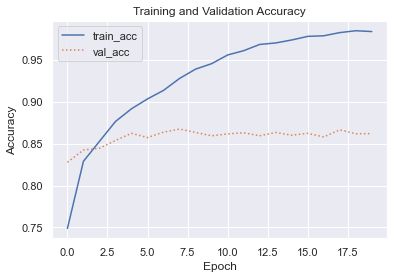

In [104]:
acc = lstm_model_fitted.history['accuracy']
val = lstm_model_fitted.history['val_accuracy']
epochs = range(num_epochs)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_acc','val_acc'],loc='upper left')
#plt.legend(loc='upper left')
plt.plot()

[]

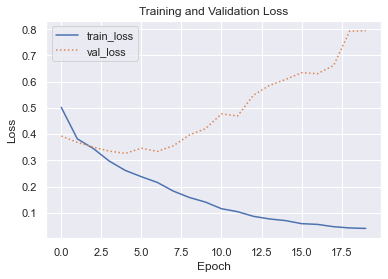

In [105]:
loss = lstm_model_fitted.history['loss']
val = lstm_model_fitted.history['val_loss']
epochs = range(num_epochs)

plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'],loc='upper left')
#plt.legend(loc='upper left')
plt.plot()

#### The Bi-directional LSTM model has given an accuracy score of 86.21% in test set.

# THE END